# Attempting steady state

Steady state = all parameters remain constant throughout all pitch periods.

For `NP=3`, results in ~ 7x speedup with nearly identical results. But still over 1 hr with nested sampling.

## Next

- Profile program
- Try original delta_bijector() in model.py
- jaxns
- fix var_sigma to be 1

In [1]:
%run init.ipy

from lib import constants
from lib import klatt
from lib import util
from inv import model
from inv import process

2024-02-12 16:03:48.174712: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-12 16:03:49.055583: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-12 16:03:49.055717: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-02-12 16:03:49.055730: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

In [2]:
path = __datadir__("OPENGLOT/RepositoryI/Vowel_O/O_normal_200Hz.wav")

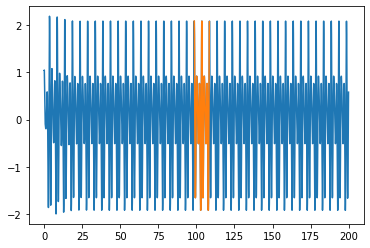

In [3]:
from scipy.io import wavfile
fs, rawdata = wavfile.read(path)

data = process.process_data(rawdata, fs, max_NP=3)

plot(data['fullt'], data['fulld'])
plot(data['t'], data['d'])

(array([ 98.6, 103.6, 108.6]),
 array([[          nan,           nan,           nan],
        [ 585.08020774, 2364.10460151, 2958.49149314],
        [ 585.07962237, 2364.10900539, 2958.51707931]]))

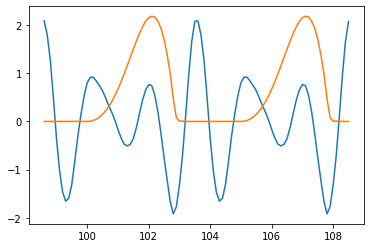

In [4]:
plot(data['t'], data['d'])
plot(data['t'], data['aux'])

data['pulse_estimate'], data['F_estimate']

`F_estimate` from Praat is off the mark and our prior will follow it too eagerly, missing low freq poles which are then emulated by wiggly GFs. Setting it to missing for $K=3$ also results in our prior being too constrained. So for now we simply set the estimates to their true values.

In [5]:
F_true = np.vstack([[570., 840., 2410.]]*3)
data['F_estimate'] = F_true

NP = 3
Number of data points: 100
Number of model dimensions: 13


({'kernel_name': 'Matern32Kernel',
  'kernel_M': 128,
  'use_oq': True,
  'impose_null_integral': True},
 AllPoleFilter(3))

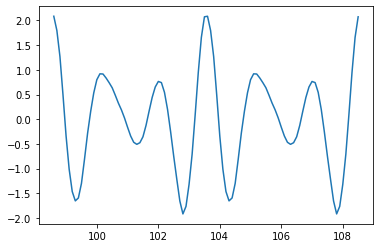

In [18]:
from inv import model
from inv import process
from vtr.prior import filter
import jax

source_config = dict(
    kernel_name = "Matern32Kernel",
    kernel_M = 128,
    use_oq = True,
    impose_null_integral = True
)

vtfilter = filter.AP(3, numpy_backend=jax.numpy, scipy_backend=jax.scipy)

ftril = process.get_source_amplitudes_tril(
    data['NP'], source_config['kernel_M']
)

hyper = dict(
    meta = dict(
        constant = True, # Steady state for source and filter params (including g)
        noiseless_estimates = False,
        bf = constants.BOUNDARY_FACTOR,
        rho = .5, # Peak picking
        inference_method = "nested_sampling",
        inference_method_options = {}
    ),
    ftril = ftril,
    data = data,
    source = source_config,
    filter = vtfilter
)

plot(hyper['data']['t'], hyper['data']['d'])
print("NP =", hyper['data']['NP'])
print("Number of data points:", len(hyper['data']['d']))
print("Number of model dimensions:", model.ndim(hyper))

display(klatt.play(hyper['data']['t'], hyper['data']['d']))

hyper['source'], hyper['filter']

In [42]:
prior = model.theta_trajectory_prior(hyper)
theta = prior.sample(seed=jaxkey())
theta

[Memory]1306.8s, 21.8min: Loading posterior_of_fitted_lf_values...
[Memory]1306.9s, 21.8min: Loading run_nested...
[Memory]1306.9s, 21.8min: Loading posterior_of_fitted_TFB_values...
[Memory]1307.0s, 21.8min: Loading run_nested...


{'noise_sigma': DeviceArray(0.04807108, dtype=float64),
 'delta': DeviceArray(0.1023229, dtype=float64),
 'source': DeviceArray([[3.27890895, 0.41358594, 5.03896184, 0.82192039],
              [3.27890895, 0.41358594, 5.03896184, 0.82192039],
              [3.27890895, 0.41358594, 5.03896184, 0.82192039]],            dtype=float64),
 'filter': DeviceArray([[ 678.93399143, 1253.60287522, 2747.0847737 ,   96.90969542,
                 53.36323779,  263.21460479],
              [ 678.93399143, 1253.60287522, 2747.0847737 ,   96.90969542,
                 53.36323779,  263.21460479],
              [ 678.93399143, 1253.60287522, 2747.0847737 ,   96.90969542,
                 53.36323779,  263.21460479]], dtype=float64),
 'g': DeviceArray([[-0.33244191],
              [-0.33244191],
              [-0.33244191]], dtype=float64)}

In [43]:
prior.log_prob(theta) # Log prob of prior fails, but not necessary for nested sampling

ValueError: Differences between `event_ndims` and `min_event_ndims must be equal for all elements of the structured input. Saw event_ndims={'noise_sigma': 0, 'delta': 0, 'source': 1, 'filter': 1, 'g': 1}, min_event_ndims={'noise_sigma': 0, 'delta': 0, 'source': 2, 'filter': 2, 'g': 2}.

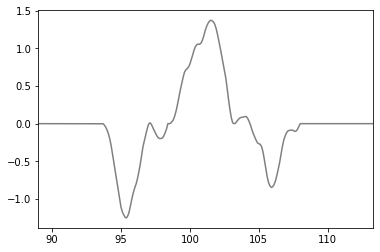

In [81]:
theta = prior.sample(seed=jaxkey())
noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)

hyper2 = process.hyper_fullt(hyper)

R = model.full_kernelmatrix_root(
    delta, theta_source, theta_filter, hyper2, convolve=False, integrate=True
)

#plot(hyper['data']['t'], hyper['data']['d'])

nsamp = 1
for _ in range(nsamp):
    w = model.randf(hyper)
    f = R @ w
    plot(hyper['data']['fullt'], f, color='grey', alpha=1/sqrt(nsamp))

process.setxlim(f, hyper)

klatt.play(hyper['data']['t'], f)

## Test NS algorithm on "steady state" (consant=True)

In [82]:
import dynesty
import scipy
from inv import model

theta_bijector = model.theta_trajectory_bijector(hyper)
    
@jax.jit
def loglike(w):
    theta = theta_bijector.forward(w)
    logl = model.full_likelihood(theta, hyper)
    return logl

ptform = scipy.special.ndtri

ndim = model.ndim(hyper)
ndim

[Memory]1740.5s, 29.0min: Loading posterior_of_fitted_lf_values...
[Memory]1740.5s, 29.0min: Loading run_nested...
[Memory]1740.6s, 29.0min: Loading posterior_of_fitted_TFB_values...
[Memory]1740.6s, 29.0min: Loading run_nested...


13

In [83]:
w = ptform(rand(ndim))
loglike(w), theta_bijector.forward(w)

(DeviceArray(-59.92562258, dtype=float64),
 {'noise_sigma': DeviceArray(0.3449998, dtype=float64),
  'delta': DeviceArray(0.21807472, dtype=float64),
  'source': DeviceArray([[5.00830443, 0.57371518, 4.76146626, 0.77612645],
               [5.00830443, 0.57371518, 4.76146626, 0.77612645],
               [5.00830443, 0.57371518, 4.76146626, 0.77612645]],            dtype=float64),
  'filter': DeviceArray([[ 753.5914484 , 1415.31579629, 2502.24248604,   92.62525811,
                 163.95747539,   49.52347966],
               [ 753.5914484 , 1415.31579629, 2502.24248604,   92.62525811,
                 163.95747539,   49.52347966],
               [ 753.5914484 , 1415.31579629, 2502.24248604,   92.62525811,
                 163.95747539,   49.52347966]], dtype=float64),
  'g': DeviceArray([[2.97998437],
               [2.97998437],
               [2.97998437]], dtype=float64)})

In [84]:
SAMPLERARGS = {'sample': 'rslice', 'first_update': {'min_eff': 5.}}
RUNARGS = {'save_bounds': False, 'maxcall': int(1e7)}

# Could use 10% stopping criteria as in Petrosyan+ 2023
sampler = dynesty.NestedSampler(
    loglike, ptform, ndim, nlive=3*ndim, **SAMPLERARGS
)

sampler.run_nested(**RUNARGS)
results = sampler.results

2112it [1:19:02,  2.25s/it, +39 | bound: 169 | nc: 1 | ncall: 181586 | eff(%):  1.185 | loglstar:   -inf < 227.576 <    inf | logz: 177.143 +/-  1.024 | dlogz:  0.001 >  0.048]


Summary
nlive: 39
niter: 2112
ncall: 181547
eff(%):  1.185
logz: 177.143 +/-  1.060


None

'Information (bans)'

17.718027286912594

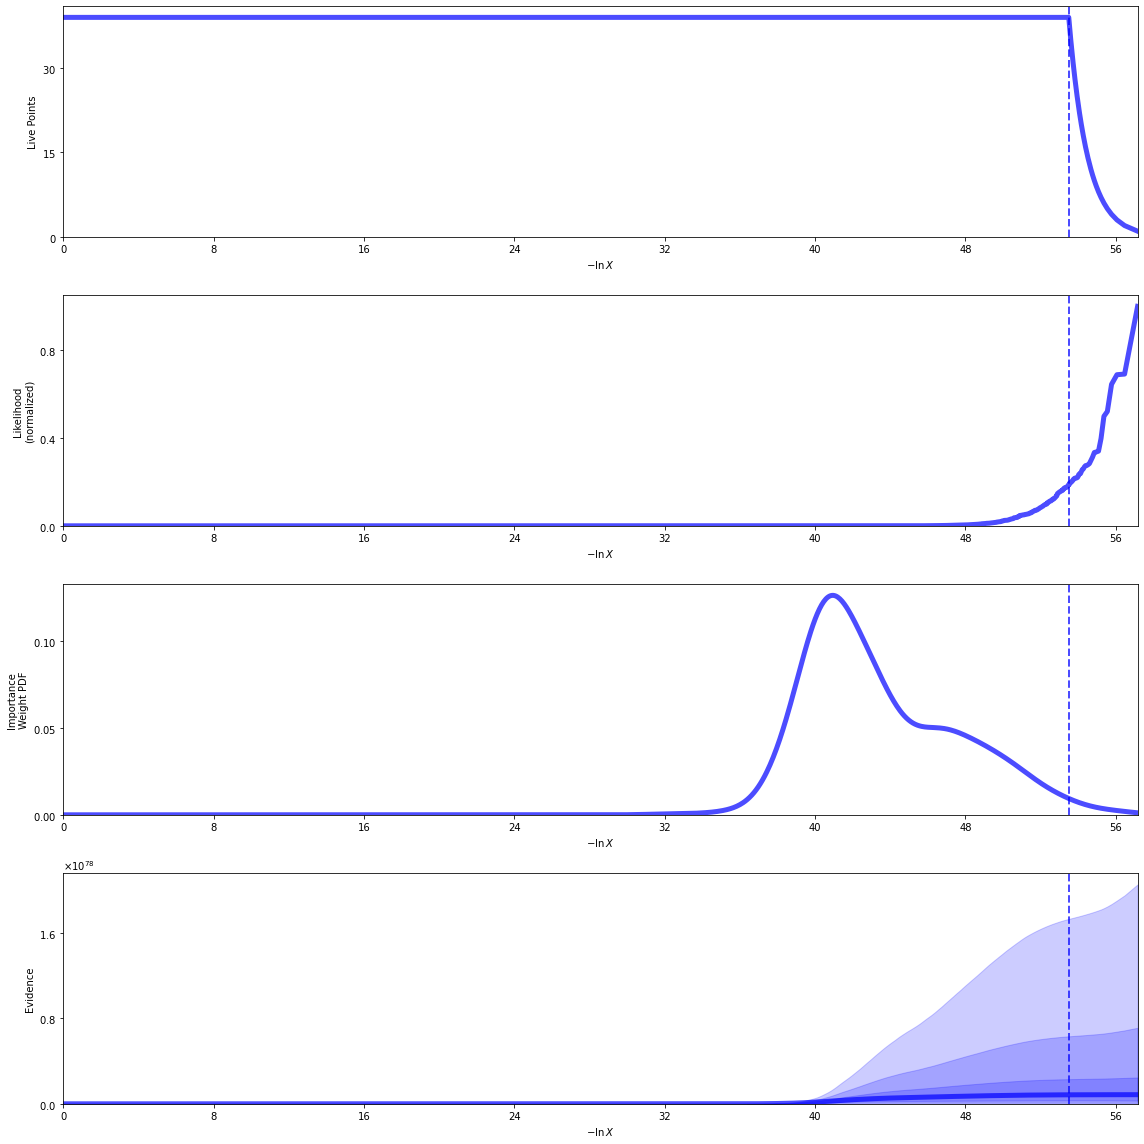

Quantiles:
$x_{1}$ [(0.025, -2.592000017862668), (0.5, -2.396819241555866), (0.975, -2.156850706950993)]
Quantiles:
$x_{2}$ [(0.025, 0.8888365360166937), (0.5, 1.7847219895989956), (0.975, 3.246823503368765)]
Quantiles:
$x_{3}$ [(0.025, -1.868993666138463), (0.5, -1.4359164323316125), (0.975, -1.0594417467505544)]
Quantiles:
$x_{4}$ [(0.025, -2.943777595290223), (0.5, -2.355887054373619), (0.975, -1.8860018652084574)]
Quantiles:
$x_{5}$ [(0.025, -0.49705877851722574), (0.5, -0.3864384549562194), (0.975, -0.27244678059383115)]
Quantiles:
$x_{6}$ [(0.025, 0.060909718388161095), (0.5, 0.5954327207599845), (0.975, 0.9712929838662034)]
Quantiles:
$x_{7}$ [(0.025, -0.36132316978098367), (0.5, -0.3237302021176964), (0.975, -0.2708278889368996)]
Quantiles:
$x_{8}$ [(0.025, -1.6197731450689465), (0.5, -1.5417040616891078), (0.975, -1.4091087753508569)]
Quantiles:
$x_{9}$ [(0.025, 0.626320977816938), (0.5, 0.7598537821327035), (0.975, 0.8989148650352636)]
Quantiles:
$x_{10}$ [(0.025, -1.93796979

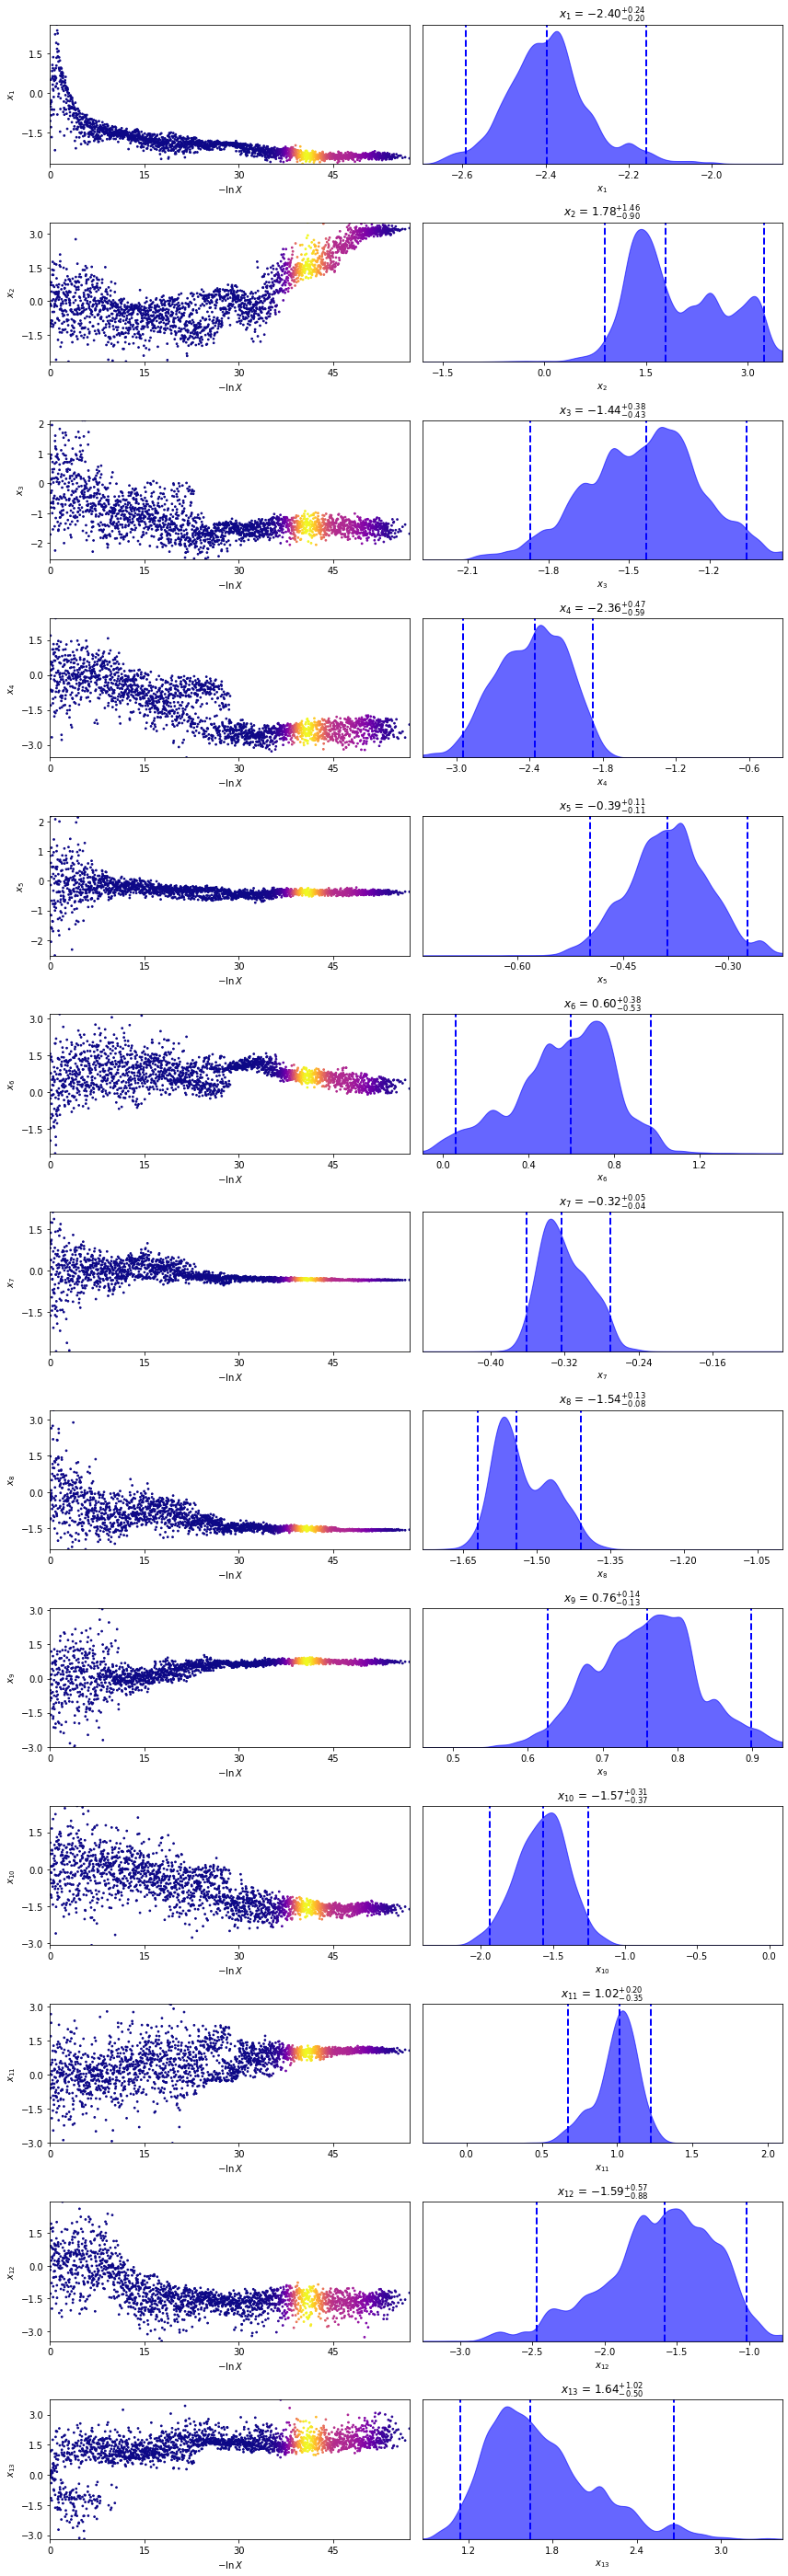

In [85]:
util.dyplot(results, runplot=True, traceplot=True, cornerplot=False)

In [86]:
@jax.jit
def lstsq(R, y, noise_power):
    D = jnp.eye(R.shape[1])
    Z = noise_power * D + R.T @ R
    L, lower = jax.scipy.linalg.cho_factor(Z, lower=True, check_finite=False)
    b = R.T @ y
    x = jax.scipy.linalg.cho_solve((L, lower), b, check_finite=False)
    return x

0	log L = 222.89979320066243	SNR [dB] = 39.71916084720699


{'noise_sigma': DeviceArray(0.01032861, dtype=float64),
 'delta': DeviceArray(1.05112887, dtype=float64),
 'source': DeviceArray([[0.96430232, 0.035123  , 4.99948629, 0.52638893],
              [0.96430232, 0.035123  , 4.99948629, 0.52638893],
              [0.96430232, 0.035123  , 4.99948629, 0.52638893]],            dtype=float64),
 'filter': DeviceArray([[ 571.78444752,  843.58400211, 2378.61269937,   63.03185899,
                117.1786691 ,   52.52056374],
              [ 571.78444752,  843.58400211, 2378.61269937,   63.03185899,
                117.1786691 ,   52.52056374],
              [ 571.78444752,  843.58400211, 2378.61269937,   63.03185899,
                117.1786691 ,   52.52056374]], dtype=float64),
 'g': DeviceArray([[1.68561049],
              [1.68561049],
              [1.68561049]], dtype=float64)}

1	log L = 213.4040518460074	SNR [dB] = 39.375746227151765


{'noise_sigma': DeviceArray(0.01074516, dtype=float64),
 'delta': DeviceArray(0.44208018, dtype=float64),
 'source': DeviceArray([[0.46393288, 0.02675067, 4.99150695, 0.64559989],
              [0.46393288, 0.02675067, 4.99150695, 0.64559989],
              [0.46393288, 0.02675067, 4.99150695, 0.64559989]],            dtype=float64),
 'filter': DeviceArray([[ 573.47242867,  851.98339273, 2405.00993442,   63.5879608 ,
                106.1989703 ,   60.61986795],
              [ 573.47242867,  851.98339273, 2405.00993442,   63.5879608 ,
                106.1989703 ,   60.61986795],
              [ 573.47242867,  851.98339273, 2405.00993442,   63.5879608 ,
                106.1989703 ,   60.61986795]], dtype=float64),
 'g': DeviceArray([[3.33852982],
              [3.33852982],
              [3.33852982]], dtype=float64)}

2	log L = 217.9046501359254	SNR [dB] = 41.1932354279542


{'noise_sigma': DeviceArray(0.00871642, dtype=float64),
 'delta': DeviceArray(0.71456759, dtype=float64),
 'source': DeviceArray([[0.72726223, 0.03287038, 4.9788693 , 0.600138  ],
              [0.72726223, 0.03287038, 4.9788693 , 0.600138  ],
              [0.72726223, 0.03287038, 4.9788693 , 0.600138  ]],            dtype=float64),
 'filter': DeviceArray([[ 570.58549558,  842.01815916, 2406.01690446,   60.66741233,
                103.22675151,   80.22097511],
              [ 570.58549558,  842.01815916, 2406.01690446,   60.66741233,
                103.22675151,   80.22097511],
              [ 570.58549558,  842.01815916, 2406.01690446,   60.66741233,
                103.22675151,   80.22097511]], dtype=float64),
 'g': DeviceArray([[2.4568544],
              [2.4568544],
              [2.4568544]], dtype=float64)}

3	log L = 219.94422588670346	SNR [dB] = 41.03795210003645


{'noise_sigma': DeviceArray(0.00887365, dtype=float64),
 'delta': DeviceArray(0.83852783, dtype=float64),
 'source': DeviceArray([[0.59345295, 0.03325266, 4.98848921, 0.56363995],
              [0.59345295, 0.03325266, 4.98848921, 0.56363995],
              [0.59345295, 0.03325266, 4.98848921, 0.56363995]],            dtype=float64),
 'filter': DeviceArray([[ 573.05001791,  847.29395961, 2383.81113034,   58.43592841,
                102.81815647,   82.50519108],
              [ 573.05001791,  847.29395961, 2383.81113034,   58.43592841,
                102.81815647,   82.50519108],
              [ 573.05001791,  847.29395961, 2383.81113034,   58.43592841,
                102.81815647,   82.50519108]], dtype=float64),
 'g': DeviceArray([[3.21299226],
              [3.21299226],
              [3.21299226]], dtype=float64)}

4	log L = 214.21593775485326	SNR [dB] = 38.335455909825825


{'noise_sigma': DeviceArray(0.01211232, dtype=float64),
 'delta': DeviceArray(0.61934437, dtype=float64),
 'source': DeviceArray([[0.72215554, 0.04010542, 5.01229979, 0.60701833],
              [0.72215554, 0.04010542, 5.01229979, 0.60701833],
              [0.72215554, 0.04010542, 5.01229979, 0.60701833]],            dtype=float64),
 'filter': DeviceArray([[ 575.75082043,  857.28646558, 2398.15199781,   58.741785  ,
                 97.01387119,   83.63459339],
              [ 575.75082043,  857.28646558, 2398.15199781,   58.741785  ,
                 97.01387119,   83.63459339],
              [ 575.75082043,  857.28646558, 2398.15199781,   58.741785  ,
                 97.01387119,   83.63459339]], dtype=float64),
 'g': DeviceArray([[2.11767135],
              [2.11767135],
              [2.11767135]], dtype=float64)}

DeviceArray(0.61934437, dtype=float64)

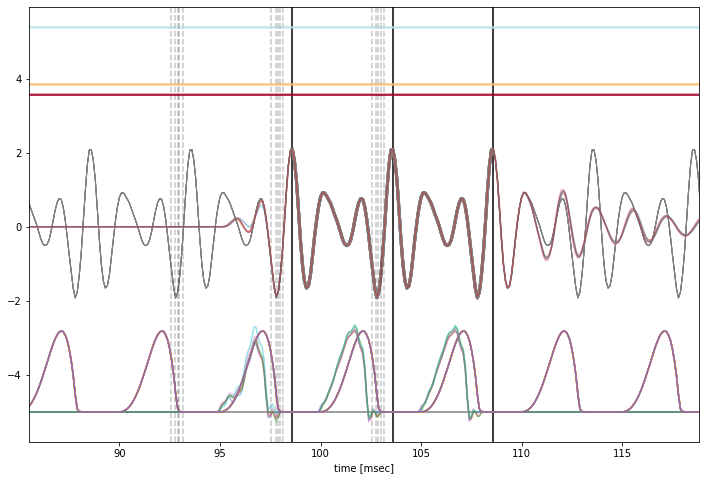

In [118]:
nsamp = 5

w_samples = util.resample_equal(results, nsamp)

figsize(12, 8)
axhline(-5, color="grey")

for pest in hyper['data']['pulse_estimate']: axvline(pest, color="black")

for i, w_sample in enumerate(w_samples):
    print(i, end='\t')
    
    theta = theta_bijector.forward(w_sample)
    print("log L =", model.full_likelihood(theta, hyper), end='\t')

    noise_sigma, delta, theta_source, theta_filter = model.unpack_theta(theta, hyper)
    offset = model.get_offset(delta, theta_source, hyper)
    print("SNR [dB] =", -20*log10(noise_sigma))

    display(theta)

    R = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper, convolve=True
    )

    f_mean = lstsq(R, hyper['data']['d'], noise_sigma**2)

    hyper2 = process.hyper_fullt(hyper)
    R2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=True
    )

    R_gfd2 = model.full_kernelmatrix_root(
        delta, theta_source, theta_filter, hyper2, convolve=False, integrate=True
    )

    ft = R2 @ f_mean
    gf = R_gfd2 @ f_mean

    # Just a heuristic
    gf_scaled = theta['g'].mean() * gf

    
    alpha = 1/sqrt(nsamp)
    plot(hyper['data']['fullt'], hyper['data']['fulld'], color="grey", label="data", lw=1)
    plot(hyper['data']['t'], hyper['data']['d'], color="grey", label="data", lw=3)
    plot(hyper['data']['fullt'], gf_scaled - 5, label="GF", alpha=alpha)
    plot(hyper['data']['fullt'], ft, label="f(t)", alpha=alpha)
    plot(hyper['data']['fullt'], hyper['data']['fullaux'] - 5, label="truth")
    for tp in offset: axvline(tp, ls="--", color="black", alpha=.5*alpha)
    xlabel("time [msec]")
    setxlim(gf, .1)
    #legend()
    
    for k, x in enumerate(theta_filter['x'].T):
        x_interp = np.interp(
            hyper['data']['fullt'], offset + theta_source['T']/2, x
        )
        plot(
            hyper['data']['fullt'], 3 + x_interp/1000,
            alpha=alpha, color=plt.cm.RdYlBu(k/hyper['filter'].K)
        )

    #display(klatt.play(hyper['data']['t'], hyper['data']['d']))
    #display(klatt.play(hyper['data']['t'], ft))

delta

In [116]:
model.unpack_theta(theta, hyper)

(DeviceArray(0.00943643, dtype=float64),
 DeviceArray(0.5501844, dtype=float64),
 {'Oq': DeviceArray([0.61406257, 0.61406257, 0.61406257], dtype=float64),
  'T': DeviceArray([5.03161707, 5.03161707, 5.03161707], dtype=float64),
  'r': DeviceArray([0.02914056, 0.02914056, 0.02914056], dtype=float64),
  'var_sigma': DeviceArray([0.56288428, 0.56288428, 0.56288428], dtype=float64)},
 {'g': DeviceArray([[3.02656883],
               [3.02656883],
               [3.02656883]], dtype=float64),
  'x': DeviceArray([[ 579.88216174,  867.92020288, 2421.59919559],
               [ 579.88216174,  867.92020288, 2421.59919559],
               [ 579.88216174,  867.92020288, 2421.59919559]],            dtype=float64),
  'y': DeviceArray([[63.65096583, 88.92152018, 70.94932766],
               [63.65096583, 88.92152018, 70.94932766],
               [63.65096583, 88.92152018, 70.94932766]], dtype=float64)})

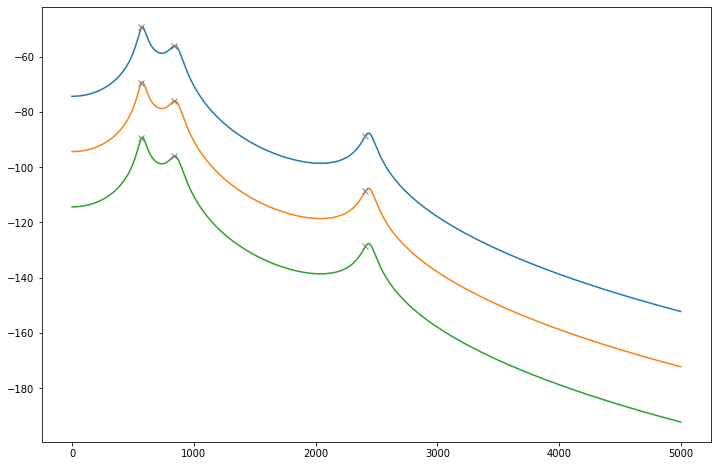

In [94]:
f = constants.spectrum_frequencies()

powers = jax.vmap(hyper['filter'].transfer_function_power_dB, (None, 0, 0, 0))(
    f, theta_filter['x'], theta_filter['y'], theta_filter['g']
)

for i, power in enumerate(powers):
    plot(f, power - i*20)
    
    F = hyper['data']['F_estimate'][i,:]
    estim = np.interp(F, f, power - i*20)
    plot(F, estim, 'x', color="grey")